In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import brewer2mpl
import colorsys
import math
import dendropy as dp
import json
import pickle as pkl

from datetime import datetime
from Bio import AlignIO, SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Levenshtein import distance
from itertools import combinations, product, permutations
from time import time
from __future__ import division
from collections import Counter, defaultdict
from copy import deepcopy
from random import shuffle, choice, sample
from scipy.stats.mstats import mquantiles
from scipy.stats import norm, expon, poisson, binom
from scipy.misc import comb
from IPython.display import Math
from networkx.readwrite import json_graph 

%matplotlib inline

In [2]:
G = nx.read_gpickle('20141103 All IRD Final Graph.pkl')

In [3]:
segments = range(1,9)
coassort_counts = dict()
for s1, s2 in combinations(segments, 2):
#     print(s1)
    if s1 not in coassort_counts.keys():
        coassort_counts[s1] = dict()
        
    coassort_counts[s1][s2] = 0
coassort_counts        

{1: {2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0},
 2: {3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0},
 3: {4: 0, 5: 0, 6: 0, 7: 0, 8: 0},
 4: {5: 0, 6: 0, 7: 0, 8: 0},
 5: {6: 0, 7: 0, 8: 0},
 6: {7: 0, 8: 0},
 7: {8: 0}}

In [4]:
# Code to encode nodes according to reassortant status type
for sc, sk, d in G.edges(data=True):
    if d['edge_type'] == 'reassortant':
        G.node[sk]['node_type'] = 'reassortant'
    if d['edge_type'] == 'full_complement':
        G.node[sk]['node_type'] = 'full_complement'

for n, d in G.nodes(data=True):
    if 'node_type' not in d.keys():
        G.node[n]['node_type'] = 'source'

In [5]:
for n, nd in G.nodes(data=True):
    coassortment_sets = []
    if nd['node_type'] == 'reassortant':
        in_edges = G.in_edges(n, data=True)
        for _, _, ed in in_edges:
            segment_combinations = combinations(ed['segments'].keys(), 2)
            for segcomb in segment_combinations:
                if set(segcomb) not in coassortment_sets:
                    coassortment_sets.append(set(segcomb))
    for cs in coassortment_sets:
        seg1 = min(cs)
        seg2 = max(cs)
        coassort_counts[seg1][seg2] += 1

In [6]:
coassort_counts

{1: {2: 1112, 3: 1112, 4: 780, 5: 1142, 6: 859, 7: 1126, 8: 1086},
 2: {3: 1166, 4: 857, 5: 1167, 6: 869, 7: 1119, 8: 1060},
 3: {4: 768, 5: 1211, 6: 718, 7: 1085, 8: 1093},
 4: {5: 793, 6: 997, 7: 952, 8: 835},
 5: {6: 770, 7: 1146, 8: 1128},
 6: {7: 927, 8: 883},
 7: {8: 1109}}

In [7]:
segG = nx.Graph()

for seg1 in coassort_counts.keys():
    for seg2 in coassort_counts[seg1].keys():
        segG.add_edge(seg1, seg2, count=coassort_counts[seg1][seg2])

In [8]:
segG.edges(data=True)

[(1, 2, {'count': 1112}),
 (1, 3, {'count': 1112}),
 (1, 4, {'count': 780}),
 (1, 5, {'count': 1142}),
 (1, 6, {'count': 859}),
 (1, 7, {'count': 1126}),
 (1, 8, {'count': 1086}),
 (2, 3, {'count': 1166}),
 (2, 4, {'count': 857}),
 (2, 5, {'count': 1167}),
 (2, 6, {'count': 869}),
 (2, 7, {'count': 1119}),
 (2, 8, {'count': 1060}),
 (3, 4, {'count': 768}),
 (3, 5, {'count': 1211}),
 (3, 6, {'count': 718}),
 (3, 7, {'count': 1085}),
 (3, 8, {'count': 1093}),
 (4, 5, {'count': 793}),
 (4, 6, {'count': 997}),
 (4, 7, {'count': 952}),
 (4, 8, {'count': 835}),
 (5, 6, {'count': 770}),
 (5, 7, {'count': 1146}),
 (5, 8, {'count': 1128}),
 (6, 7, {'count': 927}),
 (6, 8, {'count': 883}),
 (7, 8, {'count': 1109})]

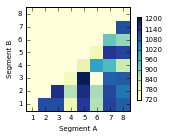

In [26]:
A = nx.to_numpy_matrix(segG, weight='count')
A = pd.DataFrame(A)
# A
fig = plt.figure(figsize=(2.5, 2))
ax = fig.add_subplot(111)
heatmap = plt.pcolor(np.triu(A), cmap='YlGnBu')
heatmap.set_clim(vmin=min(d['count'] for _, _, d in segG.edges(data=True)), vmax=max(d['count'] for _, _, d in segG.edges(data=True)))
plt.colorbar(shrink=0.8)
ax.set_xlabel('Segment A')
ax.set_ylabel('Segment B')
plt.xticks(np.arange(1,9)-0.5, np.arange(1,9))
plt.yticks(np.arange(1,9)-0.5, np.arange(1,9))
plt.subplots_adjust(bottom=0.18, left=0.05, right=0.9, top=0.9)
ax.set_aspect('equal')
plt.savefig('Coassortment Frequencies.pdf')

A.to_csv('Coassortment Frequencies.csv')
